# EARLY PREDICTION USING YOLOv3

### BACKGROUND OF YOLO

>> YOLO (You look only once) is an object detection and localization algorithm which is known mostly for its speed of functioning. There have been three versions of this algorithm, namely YOLOv1, YOLO9000 (YOLOv2) and YOLOv3.

<br>

>> YOLOv2 was based on the darknet-19 architecture with some customizations. It had a total of 23 layers for objection and localization. Though it was fast, one of its drawbacks was that it was not very accurate when compared to its competitors. One of the reasons for this is that it couldent detect small objects as the receptive field of the network lost the information related to these small objects due to convolution and pooling. Another problem was that the predicted bonding boxes were sometimes out of context and wrongly mapped. These problems were resolved in YOLOv3.

<br>

## YOLOv3
>> The actual paper itself [YOLOv3: An Incremental Improvement](https://arxiv.org/abs/1804.02767)

<br>

>>YOLOv3 is the latest in this line of detection algorithms. The earlier versions of YOLO ran at 45 FPS but it was not the most accurate. To make the network more accurate the speed was traded off. YOLOv3 runs at 30 FPS which is not very bad, but is way more accurate than its previous versions and competitors. One of the reasons for this lower FPS was higher computations. The higher computations is becaues of a very deep network. YOLOv3 is based on the darknet-53 architecture. The network has a total of 106 layers. The shape of the detection kernal is basically **1 x 1 x ( B x (C + 5))**. Here B is the number of bonding boxes (Here B = 3). C here is the number of classes on which Yolov3 is trained and has to predict (Here C = 80). 5 is the number of parameters it predicts for each of the cell (i.e. x, y, w, h, objectness) and 1 x 1 is the kernal size. This network incorporates residual blocks, skip connections and upsampling which were all missing in the previous archetictures. Not only this but the network also does its prediction (detection and classification) at three different stages. The final prediction is the combination of these three predictions by considering the best prediction if the different stages make a similar prediction.

<br>

>> <img src = "https://cdn-images-1.medium.com/max/2000/1*d4Eg17IVJ0L41e7CTWLLSg.png" height = 400 width = 900>

<br>

>> From the above image it can be seen that the YOLOv3 network makes the prediction at 3 stages. These are basically at :
1. Layer 82 => The first detection takes place here. Resultant feature map is 13x13. This is obtained by downsampling the input of 416x416 by a stride of 32. Thus, the resultant output is 13x13x(3x(5+80)) = **13x13x255.** The bonding boxes predicted here are of dimensions [116, 90], [156, 198], [373, 326] which predict large and prominant objects.
2. Layer 94 => The second detection takes place here. The feature maps from the 79th layer are upsampled to dimensions of 26x26. This feature map is concatenated with the feature map from the 61st layer. The detection feature map is **26x26x255** (similr to the previous detection with the difference only in the dimensions). The bonding boxes predicted here are of dimensions [30, 61], [62, 45], [59, 119] which predicts intermediate objects. 
3. Layer 106 => This is where the final prediction takes place. The feature maps from the 91st layer are upsampled to the dimensions of 52x52. This feature map is concatened with the feature map from the 36th layer.  The detection feature map is **52x52x255**. The bonding boxes predicted here are of dimensions [10, 13], [16, 30], [33, 23] which predict and detect smmaller objects and does the final prediction.

>> Due to the presence of skip connections and multi-stage prediction with feature maps of different dimensions, the accuracy is drastically improved because the network bocomes more robust in detecting smaller objects as well, which was completely missing in the previous architectures.

<br>

>> YOLOv3 performs the detection at 3 stages as seen above and at each stage it predicts 3 anchor boxes for each cell, thus resulting in prediction of 10,647 anchor boxes in total over all the stages (i.e 13x13x3  +  26x26x3  +  52x52x3). Along with the anchor boxes it also predicts the length, width, center (x, y), objectness and the class to which the object belongs. Thus, it can be seen that the number of anchor box predictions is almost 10 times more when compared to YOLOv2.

<br>

>> The loss function is almost similar to that used in YOLOv1 and YOLOv2 with only minor changes. The changes are that the square error of the objectness and class prediction is now changed to cross-entropy loss. Due to this YOLOv3 can now also perform multi-label classification.

<br>

<img src = "https://cdn-images-1.medium.com/max/1600/1*YpNE9OQeshABhBgjyEXlLA.png">

<br>
<br>

## EARLY EXIT PREDICTION

>> Early prediction known as anytime prediction as a concept was introduced in [Multi-Scale Dense Networks for Resource Efficient Image Classification](https://arxiv.org/abs/1703.09844). The principle of this concept is that if the network can classify the image correctly with a high confidence before reching the end of the network, then the network should be allowed to make the prediction then and there so that the computation to reach the end of the network can be bypassed. This plays an important role in reducing the computation cost and time and also produce resourse efficiency which is very important in the present situation where computation is not seen as an issue, but when deploying the model computation becomes a big issue.

<br>

<img src ="https://cloud.githubusercontent.com/assets/6460942/26835456/61a77e08-4aa6-11e7-82be-7eb09a765d7c.png" height = 300>

<br>
<br>

## IMPLEMENTING EARLY PREDICTION IN YOLOv3

>> The process of early prediction can be implemented in YOLOv3 to predict the class of each object present in  the image. 

<br>

>>One of the ideas is to consider any one of the final few layers can be be utilized for this task. There can be a dense connection between the selected layer and the newly implemented output layer to make the class prediction. There is no softmax used but a multi-class prediction can be made using the the cross entrophy loss function. Another idea is to take the pre-existing output stages in the YOLOv3 architecture and implement detection at each of these stages individually. The threshold here could be the prediction and detection accuracy on the input image. This method will not only help in classification like in the above case but also help in detection because this network is trained for detection.


<br>
<br>




## DARKNET 53 ARCHITECTURE

>> The YOLOv3 is based on the basic architecture of Darknet-53 architecture. The architecture is a combination of convolution blocks and residual blocks stacked alternatively. Each of these blocks is made up of 2D convolutional layers. The 53 layers is broken alternatively between the Convolution units and the residual units. The overall architecture is defined in the darknet_base function with the number of layers in each block as specified in the comments in that function. (given below)

<br>

```python
"""Darknet-53 for yolo v3.
"""

'''Importing required modules to build the network'''
from keras.models import Model
from keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dense
from keras.layers import add, Activation, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.regularizers import l2


'''Defining the convolution layer'''
def conv2d_unit(x, filters, kernels, strides=1):
    """Convolution Unit
    This function defines a 2D convolution operation with BN and LeakyReLU.

    # Arguments
        x: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernels: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        strides: An integer or tuple/list of 2 integers,
            specifying the strides of the convolution along the width and
            height. Can be a single integer to specify the same value for
            all spatial dimensions.

    # Returns
            Output tensor.
    """
    x = Conv2D(filters, kernels,
               padding='same',
               strides=strides,
               activation='linear',
               kernel_regularizer=l2(5e-4))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)

    return x

  
'''Defining the residual block to implement a convolution block and concatenation of input with generated tensor'''
def residual_block(inputs, filters):
    """Residual Block
    This function defines a 2D convolution operation with BN and LeakyReLU.

    # Arguments
        x: Tensor, input tensor of residual block.
        kernels: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.

    # Returns
        Output tensor.
    """
    x = conv2d_unit(inputs, filters, (1, 1))
    x = conv2d_unit(x, 2 * filters, (3, 3))
    x = add([inputs, x])
    x = Activation('linear')(x)

    return x

  
 '''Defining a staked residual network which implements the network recursively'''
def stack_residual_block(inputs, filters, n):
    """Stacked residual Block
    
    #Arguments
      input: this is the input to the network
      fliters: number of filters
      n: number of layers required in each block
      
     #Returns
      Output tensor
    """
    x = residual_block(inputs, filters)

    for i in range(n - 1):
        x = residual_block(x, filters)

    return x

  
'''Defining the darknet model with the previously defined functions'''
def darknet_base(inputs):
    """Darknet-53 base model.
    """
    #implements a total of 53 layers
    x = conv2d_unit(inputs, 32, (3, 3))          #implements one layer

    x = conv2d_unit(x, 64, (3, 3), strides=2)  #implements one layer
    x = stack_residual_block(x, 32, n=1)       #implements two layer

    x = conv2d_unit(x, 128, (3, 3), strides=2)#implements one layer
    x = stack_residual_block(x, 64, n=2)       #implements four layer

    x = conv2d_unit(x, 256, (3, 3), strides=2)#implements one layer
    x = stack_residual_block(x, 128, n=8)     #implements sixteen layer

    x = conv2d_unit(x, 512, (3, 3), strides=2)#implements one layer
    x = stack_residual_block(x, 256, n=8)     #implements sixteen layer

    x = conv2d_unit(x, 1024, (3, 3), strides=2)#implements one layer
    x = stack_residual_block(x, 512, n=4)       #implements eight layer

    return x

  
'''This is the complete darknet architecture'''
def darknet():
    """Darknet-53 classifier.
    """
    #implements a total of 53 layers
    
    inputs = Input(shape=(416, 416, 3))
    x = darknet_base(inputs)
    
    #implements the last layer
    x = GlobalAveragePooling2D()(x)
    x = Dense(1000, activation='softmax')(x)

    model = Model(inputs, x)

    return model


if __name__ == '__main__':
    model = darknet()
    print(model.summary())

```

## MODEL OF YOLOv3 (CONVOLUTION ARCHITECTURE)

>> The convolution architecture of YOLOv3 is defined below. It is a combination of convolutional layers and blocks with residual connections, skip connections and upsampling. The padding applied to the feature maps during convolution is only on the top and left as specified in the code of the model. There is also batch normalization used with leaky ReLU as the activation function which gives slightly better results when compared to ReLU. The final output is obtained at layer 106 . This output is a combination of the best outputs from layer 82, layer 94 and layer 106 itself. This so that most of the objects in the objects in the image or video is detected with good accuracy.

```python
'''Defining the convolution block of the YOLOv3 model'''
def _conv_block(inp, convs, skip=True):
    x = inp
    count = 0
    
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
        x = Conv2D(conv['filter'], 
                   conv['kernel'], 
                   strides=conv['stride'], 
                   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
                   name='conv_' + str(conv['layer_idx']), 
                   use_bias=False if conv['bnorm'] else True)(x)
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x) # applying batch normalization
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x) # applying the leaky ReLU activation function

    return add([skip_connection, x]) if skip else x # returns a concatenated output if the skip connection is true else outputs only the result of present convolution
  

'''Defining the yolov3 model using the above defined concolution block'''  
def yolov3_model():
    input_image = Input(shape=(None, None, 3))

    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])

    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])

    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])

    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])

    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
        
    skip_36 = x
        
    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])

    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
        
    skip_61 = x
        
    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])

    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
        
    # Layer 75 => 79
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)

    # Layer 80 => 82
    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                              {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)

    # Layer 83 => 86
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])

    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)

    # Layer 92 => 94
    yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                              {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)

    # Layer 95 => 98
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])

    # Layer 99 => 106
    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
                               {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)

    model = Model(input_image, [yolo_82, yolo_94, yolo_106])    
    return model

```

## OUTPUT ARCHITECTURE OF YOLOv3 (WITH EARLY PREDICTION AND DETECTION)

>> The aim of this code is to predict the class, class prediction score and the bonding boxes of the objects present in the input image or video with early prediction and detection. 
1. The __init__  function initializes some parameters which include the object detection threshold (the object is detected only if the prediction score is greater than this value) and the non-max supression threshold.
2. The _process_feats function calculates the box prediction accuracy and the probability at each of the 3 layers (i.e layer 82, layer 94, layer 104) and outputs all the possibilities. It also outputs the box coordinates and width and height of the predicted bonding boxes.
3. The _filter_boxes function filters the various boxes predicted and only return the boxes, class, and class scores (probabilities) whose values are above the set threshold values (the ones set in the __init__ function ).
4. The _yolo_out function is the fuction which calls the above mentioned functions. The function has 9 anchor box dimensions perdefined (3 for each of the 3 output layers). This function returns the final set of anchor boxes, classes and scores of all teh objects in the image.
5. The predict function is where the early prediction is defined. The yolo model with with pretrained weights is first loaded. Then the first set of anchor boxes is used. The for loop defined in the function first checks whether the predicted scores with the defined anchor boxes is above the defined threshold of each of the objects in the image. If yes, the prediction is done and the operation is the terminated at layer 82 and the output is generated. If no, all the anchor boxes are considered and the operation is terminated at the 106th layer (final layer) and output is generated.

>>This is the operation of each of the defined functions and, how the output of YOLOv3 works with early prediction integrated.

```python
"""YOLO v3 output
"""
import numpy as np
import keras.backend as K
from keras.models import load_model

class YOLO:
    def __init__(self, obj_threshold, nms_threshold):
        """Init.

        # Arguments
            obj_threshold: Integer, threshold for object.
            nms_threshold: Integer, threshold for box.
        """
        self._t1 = obj_threshold
        self._t2 = nms_threshold
        self._yolo = load_model('data/yolo.h5')

    def _process_feats(self, out, anchors, mask):
        """process output features.

        # Arguments
            out: Tensor (N, N, 3, 4 + 1 +80), output feature map of yolo.
            anchors: List, anchors for box.
            mask: List, mask for anchors.

        # Returns
            boxes: ndarray (N, N, 3, 4), x,y,w,h for per box.
            box_confidence: ndarray (N, N, 3, 1), confidence for per box.
            box_class_probs: ndarray (N, N, 3, 80), class probs for per box.
        """
        grid_h, grid_w, num_boxes = map(int, out.shape[1: 4])

        anchors = [anchors[i] for i in mask]
        # Reshape to batch, height, width, num_anchors, box_params.
        anchors_tensor = K.reshape(K.variable(anchors),
                                   [1, 1, len(anchors), 2])
        out = out[0]
        box_xy = K.get_value(K.sigmoid(out[..., :2]))
        box_wh = K.get_value(K.exp(out[..., 2:4]) * anchors_tensor)
        box_confidence = K.get_value(K.sigmoid(out[..., 4]))
        box_confidence = np.expand_dims(box_confidence, axis=-1)
        box_class_probs = K.get_value(K.sigmoid(out[..., 5:]))

        col = np.tile(np.arange(0, grid_w), grid_w).reshape(-1, grid_w)
        row = np.tile(np.arange(0, grid_h).reshape(-1, 1), grid_h)

        col = col.reshape(grid_h, grid_w, 1, 1).repeat(3, axis=-2)
        row = row.reshape(grid_h, grid_w, 1, 1).repeat(3, axis=-2)
        grid = np.concatenate((col, row), axis=-1)

        box_xy += grid
        box_xy /= (grid_w, grid_h)
        box_wh /= (416, 416)
        box_xy -= (box_wh / 2.)
        boxes = np.concatenate((box_xy, box_wh), axis=-1)

        return boxes, box_confidence, box_class_probs

    def _filter_boxes(self, boxes, box_confidences, box_class_probs):
        """Filter boxes with object threshold.

        # Arguments
            boxes: ndarray, boxes of objects.
            box_confidences: ndarray, confidences of objects.
            box_class_probs: ndarray, class_probs of objects.

        # Returns
            boxes: ndarray, filtered boxes.
            classes: ndarray, classes for boxes.
            scores: ndarray, scores for boxes.
        """
        box_scores = box_confidences * box_class_probs
        box_classes = np.argmax(box_scores, axis=-1)
        box_class_scores = np.max(box_scores, axis=-1)
        pos = np.where(box_class_scores >= self._t1)

        boxes = boxes[pos]
        classes = box_classes[pos]
        scores = box_class_scores[pos]

        return boxes, classes, scores

    def _nms_boxes(self, boxes, scores):
        """Suppress non-maximal boxes.

        # Arguments
            boxes: ndarray, boxes of objects.
            scores: ndarray, scores of objects.

        # Returns
            keep: ndarray, index of effective boxes.
        """
        x = boxes[:, 0]
        y = boxes[:, 1]
        w = boxes[:, 2]
        h = boxes[:, 3]

        areas = w * h
        order = scores.argsort()[::-1]

        keep = []
        while order.size > 0:
            i = order[0]
            keep.append(i)

            xx1 = np.maximum(x[i], x[order[1:]])
            yy1 = np.maximum(y[i], y[order[1:]])
            xx2 = np.minimum(x[i] + w[i], x[order[1:]] + w[order[1:]])
            yy2 = np.minimum(y[i] + h[i], y[order[1:]] + h[order[1:]])

            w1 = np.maximum(0.0, xx2 - xx1 + 1)
            h1 = np.maximum(0.0, yy2 - yy1 + 1)
            inter = w1 * h1

            ovr = inter / (areas[i] + areas[order[1:]] - inter)
            inds = np.where(ovr <= self._t2)[0]
            order = order[inds + 1]

        keep = np.array(keep)

        return keep

    def _yolo_out(self, outs, shape):
        """Process output of yolo base net.

        # Argument:
            outs: output of yolo base net.
            shape: shape of original image.

        # Returns:
            boxes: ndarray, boxes of objects.
            classes: ndarray, classes of objects.
            scores: ndarray, scores of objects.
        """
        masks = [[6, 7, 8], [3, 4, 5], [0, 1, 2]]
        anchors = [[10, 13], [16, 30], [33, 23], [30, 61], [62, 45],
                   [59, 119], [116, 90], [156, 198], [373, 326]]

        boxes, classes, scores = [], [], []

        for out, mask in zip(outs, masks):
            b, c, s = self._process_feats(out, anchors, mask)
            b, c, s = self._filter_boxes(b, c, s)
            boxes.append(b)
            classes.append(c)
            scores.append(s)

        boxes = np.concatenate(boxes)
        classes = np.concatenate(classes)
        scores = np.concatenate(scores)

        # Scale boxes back to original image shape.
        width, height = shape[1], shape[0]
        image_dims = [width, height, width, height]
        boxes = boxes * image_dims

        nboxes, nclasses, nscores = [], [], []
        for c in set(classes):
            inds = np.where(classes == c)
            b = boxes[inds]
            c = classes[inds]
            s = scores[inds]

            keep = self._nms_boxes(b, s)

            nboxes.append(b[keep])
            nclasses.append(c[keep])
            nscores.append(s[keep])

        if not nclasses and not nscores:
            return None, None, None

        boxes = np.concatenate(nboxes)
        classes = np.concatenate(nclasses)
        scores = np.concatenate(nscores)

        return boxes, classes, scores

    def predict(self, image, shape):
        """Detect the objects with yolo.

        # Arguments
            image: ndarray, processed input image.
            shape: shape of original image.

        # Returns
            boxes: ndarray, boxes of objects.
            classes: ndarray, classes of objects.
            scores: ndarray, scores of objects.
        """

        outs = self._yolo.predict(image)    
        
        layer = [82, 94, 106]
        
        for i in range(1, 4):
            out = outs[:i]
            boxes, classes, scores = [], [], []
            boxes, classes, scores = self._yolo_out(out, shape)
                  
            
            for j in range(len(scores)):
                if scores[j] > 0.85:
                    if j == len(scores)-1:
                        print('Early prediction at the {}th layer !!'.format(layer[i-1]))
                        return boxes, classes, scores
                else:
                    break
                        
        print('Prediction at the 106th layer')
        return boxes, classes, scores

```

## IMPLEMENTATION OF EARLY PREDICTION IN YOLOv3 IN DETAIL

>> The idea is to detect the objects in the input image or video with least amount of computation and most efficient resource consumption. In order to achieve this what I tried to implement is a threshold on the accuracy of prediction for each object in the input image or video. This was implemented by applying the thresholding at each of the output stages discussed above. The threshold acts as a condition whether the network has to compute for the next few layers or wheher the obtained accuracy is good enough and the network can exit prediction and terminate the operation. If the prediction of the network is below the threshold then the network goes on to compute the next set of layers. This threshold parameter is an hyper-parameter which can be changed according to the users necessity, whether he wants faster prediction and less computationally expensive solution or whether he wants a prediction which is very accurate and with minimum number of false negative and false positives. 

>> The code for implementation can be found at [Early Prediction in YOLOv3](https://github.com/Vinohith/Early-prediction-on-YOLOv3). This code is a wrapper on the code of YOLOv3 by [xiaochus](https://github.com/xiaochus/YOLOv3). Though the solution I have mentioned is not a robust solution or the only solution, it is one the solutions to the problem of extensive computation power mining.  

## OUTPUTS GENERATED USING EARLY PREDICTION ON YOLOv3

In [1]:
%cd
!rm -fr Early-prediction-on-YOLOv3
!git clone https://github.com/Vinohith/Early-prediction-on-YOLOv3.git

/content
Cloning into 'Early-prediction-on-YOLOv3'...
remote: Counting objects: 448, done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 448 (delta 2), reused 0 (delta 0), pack-reused 437
Receiving objects: 100% (448/448), 4.86 MiB | 35.83 MiB/s, done.
Resolving deltas: 100% (245/245), done.


/content
/content/Early-prediction-on-YOLOv3/images/test


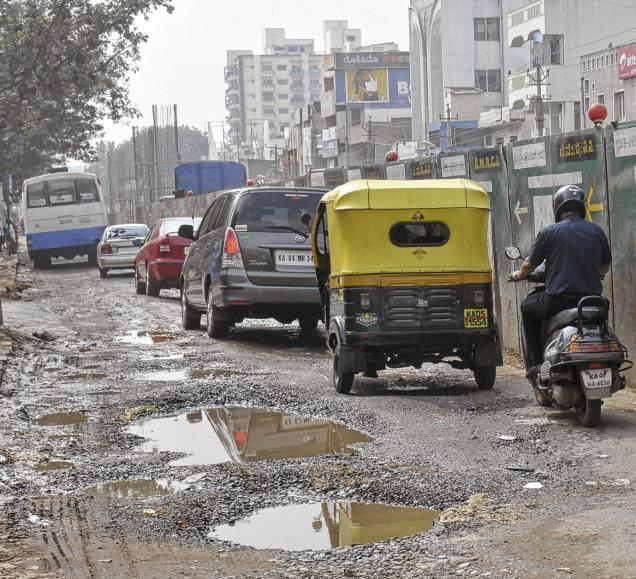

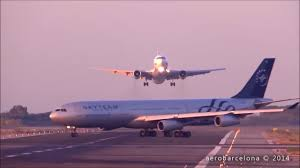

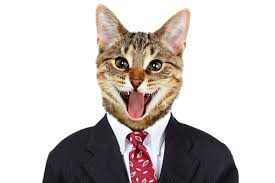

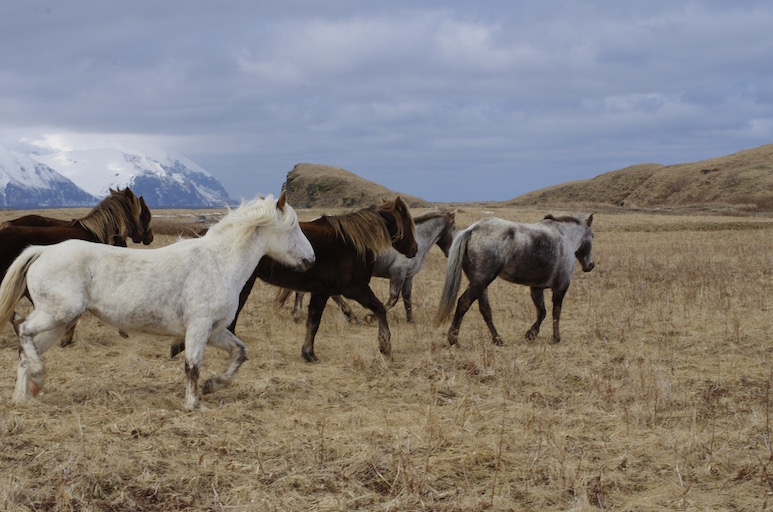

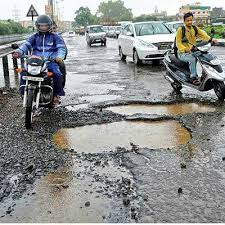

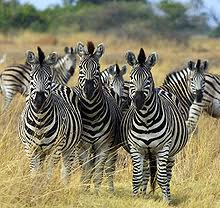

In [2]:
#These are the images on which the network is run (images before detection)

%cd
%cd Early-prediction-on-YOLOv3/images/test

from IPython.display import Image, display
display(Image('Bangalore.jpg', width='400', height='400'))
print('')
display(Image('aeroplane.jpeg', width='400', height='400'))
print('')
display(Image('cat.jpeg', width='400', height='400'))
print('')
display(Image('horses.jpg', width='400', height='400'))
print('')
display(Image('traffic.jpg', width='400', height='400'))
print('')
display(Image('zebra.jpeg', width='400', height='400'))

/content
/content/Early-prediction-on-YOLOv3/images/res


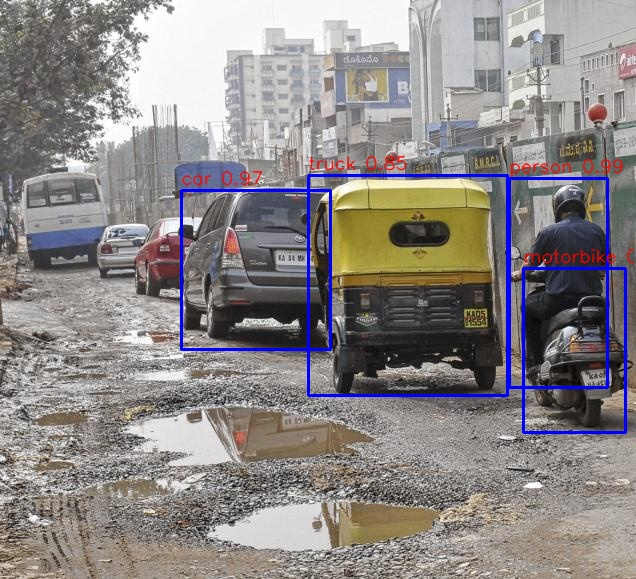

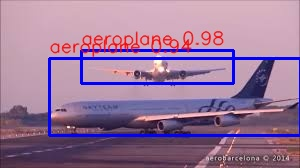

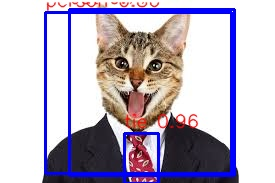

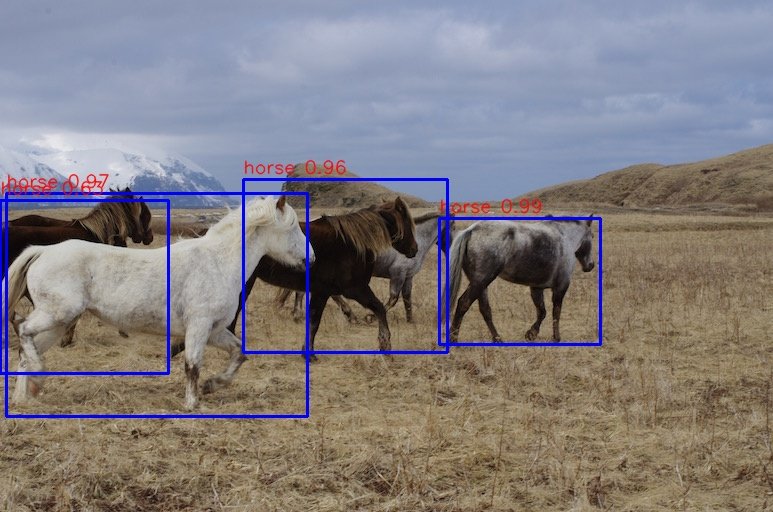

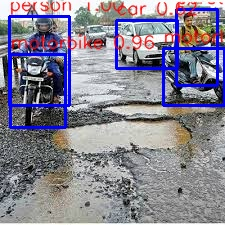

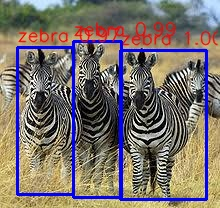

In [3]:
#These are the images after early prediction

%cd
%cd Early-prediction-on-YOLOv3/images/res

from IPython.display import Image, display
display(Image('Bangalore.jpg', width='400', height='400'))
print('')
display(Image('aeroplane.jpeg', width='400', height='400'))
print('')
display(Image('cat_res.jpeg', width='400', height='400'))
print('')
display(Image('horses.jpg', width='400', height='400'))
print('')
display(Image('traffic.jpg', width='400', height='400'))
print('')
display(Image('zebra.jpeg', width='400', height='400'))

## RUNNING THE CODE

In [4]:
%cd 
%cd Early-prediction-on-YOLOv3

#downloading the YOLOv3 weights
!wget https://pjreddie.com/media/files/yolov3.weights

/content
/content/Early-prediction-on-YOLOv3
--2018-06-30 17:18:08--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.3.39
Connecting to pjreddie.com (pjreddie.com)|128.208.3.39|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  42.3MB/s    in 6.0s    

2018-06-30 17:18:14 (39.4 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [5]:
#converting the yolov3.weights file to yolo.h5 file (keras can read and load files with extension of .h5)
!python yad2k.py cfg/yolo.cfg yolov3.weights data/yolo.h5

Using TensorFlow backend.
Loading weights.
Weights Header:  [       0        2        0 32013312        0]
Parsing Darknet config.
Creating Keras model.
Parsing section net_0
Parsing section convolutional_0
conv2d bn leaky (3, 3, 3, 32)
2018-06-30 17:18:20.212976: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:897] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2018-06-30 17:18:20.213436: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1392] Found device 0 with properties: 
name: Tesla K80 major: 3 minor: 7 memoryClockRate(GHz): 0.8235
pciBusID: 0000:00:04.0
totalMemory: 11.17GiB freeMemory: 11.10GiB
2018-06-30 17:18:20.213474: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1471] Adding visible gpu devices: 0
2018-06-30 17:18:20.584873: I tensorflow/core/common_runtime/gpu/gpu_device.cc:952] Device interconnect StreamExecutor with strength 1 edge matrix:
2018-06-30 17:18:20.584926: I ten

Total params: 62,001,757
Trainable params: 61,949,149
Non-trainable params: 52,608
__________________________________________________________________________________________________
None
Saved Keras model to data/yolo.h5
Read 62001757 of 62001757.0 from Darknet weights.


In [0]:
#instaling opencv which is needed to draw the detection boxes on the input images
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2

In [7]:
#running the early prediction on YOLOv3 algorithm
!python demo.py

Using TensorFlow backend.
2018-06-30 17:19:46.184711: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:897] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2018-06-30 17:19:46.185212: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1392] Found device 0 with properties: 
name: Tesla K80 major: 3 minor: 7 memoryClockRate(GHz): 0.8235
pciBusID: 0000:00:04.0
totalMemory: 11.17GiB freeMemory: 11.10GiB
2018-06-30 17:19:46.185251: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1471] Adding visible gpu devices: 0
2018-06-30 17:19:46.552207: I tensorflow/core/common_runtime/gpu/gpu_device.cc:952] Device interconnect StreamExecutor with strength 1 edge matrix:
2018-06-30 17:19:46.552264: I tensorflow/core/common_runtime/gpu/gpu_device.cc:958]      0 
2018-06-30 17:19:46.552286: I tensorflow/core/common_runtime/gpu/gpu_device.cc:971] 0:   N 
2018-06-30 17:19:46.552604: I tensorflow/core/common_runtime

>> It can be seen from the above detection and predictions that the image aeroplane.jpeg and the image zebra.jpeg terminated with an early prediction at layer 82, but other images had to be computed on till the last layer (106th layer) for output generation and termination. Thus, early prediction has been achieved on YOLOv3 where the number of objects in the image are few and easily detectable, whereas the network has to compute till the end to generate an output

## SOME ISSUES WITH THIS APPROACH

>> The solution implemented in this tutorial for early prediction is good but it might not always include all the objects present in the image becaue set threshold is on the class score. If the class score is satisfied it terminates early missing a few small objects which might have been recognised in the future layers due the upsamling and skip-connections present in the architecture.
This code implemented is slightly robust to this because the threshold was selected taking this situation into consideration. Thus, it can overcome this problem to some extent. Below is an example of an image with this situation.

/content
/content/Early-prediction-on-YOLOv3/images/res


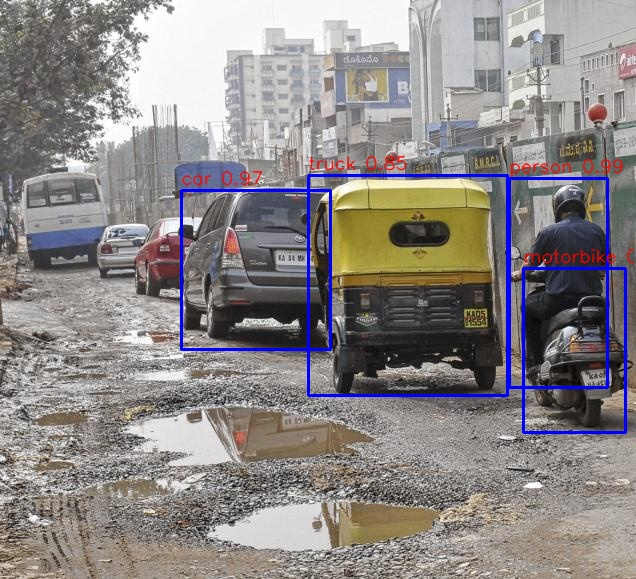

In [8]:
%cd
%cd Early-prediction-on-YOLOv3/images/res


#prediction from the implemented network due to fine-tuning of the threshold parameter
from IPython.display import Image, display
display(Image('Bangalore.jpg', width='400', height='400'))

/content
/content/Early-prediction-on-YOLOv3/images/res


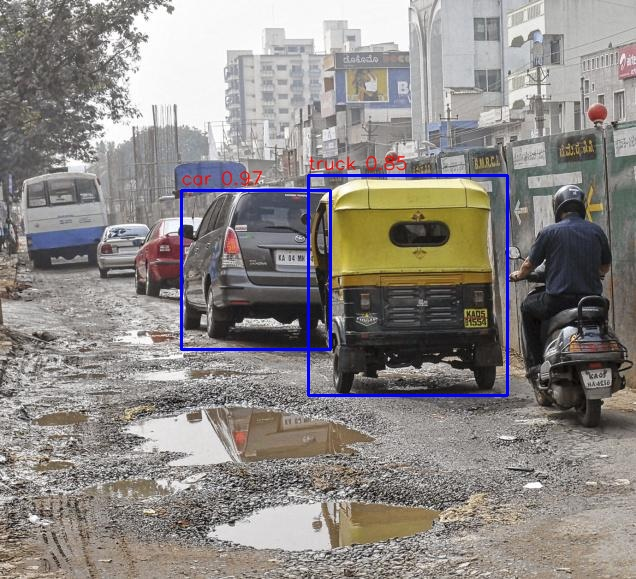

In [9]:
%cd
%cd Early-prediction-on-YOLOv3/images/res


#some objects present in the image might sometimes go un-detected to some extant
from IPython.display import Image, display
display(Image('Bangalore _early.jpg', width='400', height='400'))

>> It can be seen in the second image above that only two objects are detected, but the first image above detects four objects (even this image is missing a few objects). The code implemented for early prediction on YOLOv3 generates the first image as output and not the second image. Thus, the code implemented is robust to the problem of missing a few objects to some extent.